# Category Embedding

In [1]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import l2
from keras.optimizers import *
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
 
import xgboost as xgb

Using TensorFlow backend.


## Data Analysis:

In [2]:
train = pd.read_csv("../input/train.csv")
print("shape of train : ",train.shape)

shape of train :  (201917, 6)


In [3]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [4]:
test = pd.read_csv("../input/test.csv")
print("shape of test : ",test.shape)



shape of test :  (123623, 5)


In [5]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [6]:
merchants = pd.read_csv("../input/merchants.csv")
print("shape of merchants : ",merchants.shape)
merchants.head()


shape of merchants :  (334696, 22)


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [7]:
historical_transactions = pd.read_csv("../input/historical_transactions.csv")
historical_transactions.drop(['authorized_flag','category_1','installments','category_3','category_2','state_id','subsector_id','city_id'],axis = 1, inplace = True)
print("shape of merchants : ",historical_transactions.shape)
historical_transactions.head()

shape of merchants :  (29112361, 6)


,card_id,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date
0,C_ID_4e6213e9bc,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07
1,C_ID_4e6213e9bc,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45
2,C_ID_4e6213e9bc,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29
3,C_ID_4e6213e9bc,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26
4,C_ID_4e6213e9bc,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19


In [8]:
new_merchant_transactions = pd.read_csv("../input/new_merchant_transactions.csv")
print("shape of merchants : ",new_merchant_transactions.shape)
new_merchant_transactions.head()

shape of merchants :  (1963031, 14)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [9]:
cardCountTrain = train['card_id'].unique().size
print(cardCountTrain)
print(train['card_id'].size)
cardCountTest = test['card_id'].unique().size
print(cardCountTest)
print(test['card_id'].size)

201917
201917
123623
123623


every value of card_id in Train and test is unique.

In [10]:
cardCountTransactions = historical_transactions['card_id'].unique().size
print(cardCountTransactions)


325540


we see that: cardCountTrain + cardCountTest = cardCountTransactions,
Lets try to join the dataframes to get all the values.

Lets see the correlation of the features 1,2,3 with the target.

In [11]:
import seaborn as sns 

C:\Users\igor8\Anaconda3\envs\deep learning\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


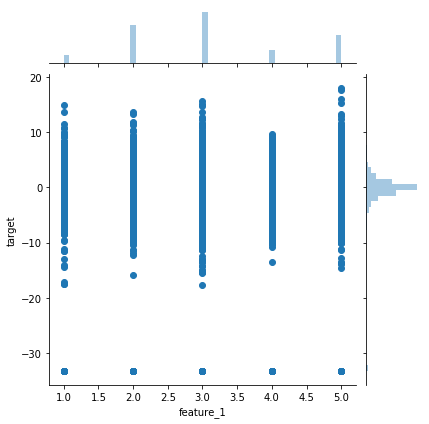

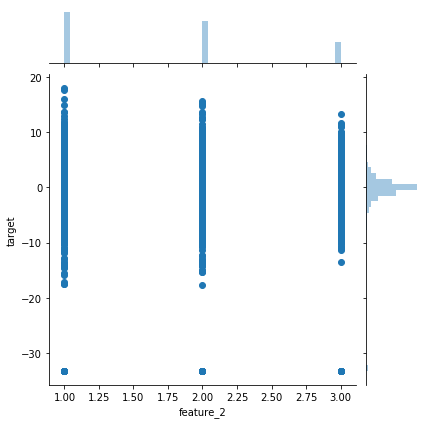

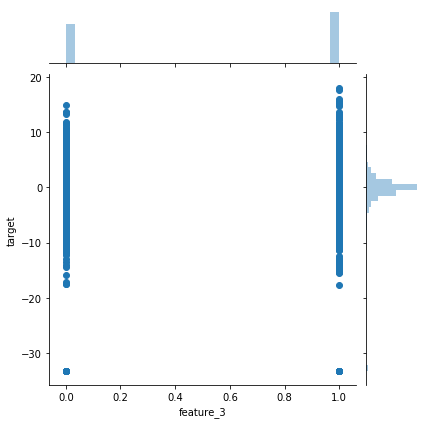

In [12]:
sns.jointplot(x=train['feature_1'], y=train['target'], data=train)  
plt.show()

sns.jointplot(x=train['feature_2'], y=train['target'], data=train)  
plt.show()

sns.jointplot(x=train['feature_3'], y=train['target'], data=train)  
plt.show()

In [13]:
print('unique merchant_id : {0}'.format(historical_transactions['merchant_id'].nunique()))
print('unique merchant_category_id : {0}'.format(historical_transactions['merchant_category_id'].nunique()))
print('unique month_lag : {0}'.format(historical_transactions['month_lag'].nunique()))
print('unique purchase_date : {0}'.format(historical_transactions['purchase_date'].nunique()))
print('unique purchase_amount : {0}'.format(historical_transactions['purchase_amount'].nunique()))

unique merchant_id : 326311
unique merchant_category_id : 327
unique month_lag : 14
unique purchase_date : 16395300
unique purchase_amount : 215014


Lets look at some features from other datasets. We can merge the transactions dataset with the train to see how other features correlate with target.


In [ ]:
joinedTrain = pd.merge(train, historical_transactions, on = 'card_id',how='left')


In [82]:
joinedTrain.head(200)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11
1,2017-06,C_ID_92a2005557,5,2,1,-0.820283,278,M_ID_c9c0f1cb3f,-7,-0.722114,2017-07-16 12:21:00
2,2017-06,C_ID_92a2005557,5,2,1,-0.820283,683,M_ID_36f9e41993,-6,-0.726171,2017-08-10 21:01:16
3,2017-06,C_ID_92a2005557,5,2,1,-0.820283,309,M_ID_b790230ee9,-2,-0.610167,2017-12-15 12:06:58
4,2017-06,C_ID_92a2005557,5,2,1,-0.820283,278,M_ID_ab67f6c982,-7,-0.307232,2017-07-08 15:13:18
5,2017-06,C_ID_92a2005557,5,2,1,-0.820283,560,M_ID_b3c49066d8,-6,-0.662158,2017-08-13 13:43:07
6,2017-06,C_ID_92a2005557,5,2,1,-0.820283,560,M_ID_b3c49066d8,-1,-0.665614,2018-01-27 06:44:29
7,2017-06,C_ID_92a2005557,5,2,1,-0.820283,560,M_ID_b3c49066d8,-7,-0.727944,2017-07-01 09:02:20
8,2017-06,C_ID_92a2005557,5,2,1,-0.820283,80,M_ID_c124c4467a,-5,-0.620986,2017-09-02 23:05:56
9,2017-06,C_ID_92a2005557,5,2,1,-0.820283,560,M_ID_1a81c358a3,-7,-0.722114,2017-07-27 08:17:48


In [15]:
joinedTrain.dropna(inplace=True)
joinedTrain.shape


(17943982, 11)

In [16]:
Train2 = joinedTrain

In [17]:
Train2.shape

(17943982, 11)

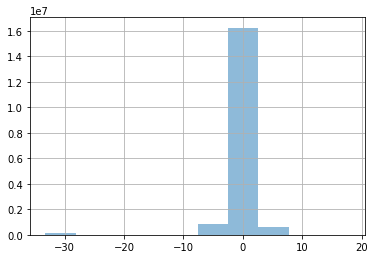

In [18]:
joinedTrain['target'].hist(alpha=0.5)

In [19]:
joinedTrain = joinedTrain.sample(500000)
joinedTrain.shape

(500000, 11)

In [20]:
joinedTest = pd.merge(test, historical_transactions, sort=False, on = 'card_id',how='inner')
joinedTest.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date
0,2017-04,C_ID_0ab67a22ab,3,3,1,412,M_ID_85a5803161,-8,-0.697320,2017-04-27 14:17:27
1,2017-04,C_ID_0ab67a22ab,3,3,1,278,M_ID_c873d839bd,-3,-0.716855,2017-09-21 22:11:57
2,2017-04,C_ID_0ab67a22ab,3,3,1,879,M_ID_9139332ccc,-6,-0.480082,2017-06-22 22:53:59
3,2017-04,C_ID_0ab67a22ab,3,3,1,80,M_ID_26c089d552,-8,-0.743902,2017-04-04 18:22:24
4,2017-04,C_ID_0ab67a22ab,3,3,1,278,M_ID_26c089d552,-2,-0.711595,2017-10-06 23:51:21


In [21]:
joinedTest.dropna(inplace=True)
joinedTest.shape

(11029843, 10)

In [6]:
from sklearn import preprocessing

target = train['target'].values
min_max_scaler = preprocessing.MinMaxScaler()
normalizedTarget = min_max_scaler.fit_transform(target.reshape(-1, 1))

In [7]:
normalizedTarget

array([[0.63298643],
       [0.6566889 ],
       [0.66245517],
       ...,
       [0.65083909],
       [0.5576449 ],
       [0.6126847 ]])

In [8]:
target

array([-0.8202826 ,  0.39291325,  0.68805599, ...,  0.09349415,
       -4.67658938, -1.85941301])

In [9]:
min_max_scaler.inverse_transform(normalizedTarget.reshape(1,-1))


array([[-0.8202826 ,  0.39291325,  0.68805599, ...,  0.09349415,
        -4.67658938, -1.85941301]])

In [66]:
first_active_month = {p:i for (i,p) in enumerate(train['first_active_month'].unique())}
card_id = {p:i for (i,p) in enumerate(train['card_id'].unique())}
#feature_1 = {p:i for (i,p) in enumerate(train['feature_1'].unique())}
#feature_2 = {p:i for (i,p) in enumerate(train['feature_2'].unique())}
#feature_3 = {p:i for (i,p) in enumerate(train['feature_3'].unique())}

In [122]:
processed_data = train.loc[:,['first_active_month','card_id','feature_1','feature_2',
                                    'feature_3']].copy()
processed_data['first_active_month'] = [first_active_month[x] for x in train['first_active_month']]
processed_data['card_id'] = [card_id[x] for x in train['card_id']]
processed_data['feature_1'] = min_max_scaler.fit_transform(train['feature_1'].values.reshape(-1, 1))
processed_data['feature_2'] = min_max_scaler.fit_transform(train['feature_2'].values.reshape(-1, 1))
processed_data['feature_3'] = min_max_scaler.fit_transform(train['feature_3'].values.reshape(-1, 1))



C:\Users\igor8\Anaconda3\envs\deep learning\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\igor8\Anaconda3\envs\deep learning\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\igor8\Anaconda3\envs\deep learning\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [153]:
processed_data

,first_active_month,card_id,feature_1,feature_2,feature_3
0,0,0,1.00,0.5,1.0
1,1,1,0.75,0.0,0.0
2,2,2,0.25,0.5,0.0
3,3,3,0.75,1.0,0.0
4,4,4,0.00,1.0,0.0
5,5,5,0.75,0.5,0.0
6,6,6,0.50,0.5,1.0
7,3,7,0.50,0.5,1.0
8,7,8,0.25,0.0,0.0
9,2,9,0.25,0.5,0.0


In [123]:
first_active_inp = Input(shape=(1,),dtype='int64')
card_inp = Input(shape=(1,),dtype='int64')
f1_inp = Input(shape=(1,),dtype='int64')
f2_inp = Input(shape=(1,),dtype='int64')
f3_inp = Input(shape=(1,),dtype='int64')

first_active_emb = Embedding(len(first_active_month),5,input_length=1)(first_active_inp)
card_emb = Embedding(len(card_id),5,input_length=1)(card_inp)
f1_emb = Embedding(len(feature_1),5,input_length=1)(f1_inp)
f2_emb = Embedding(len(feature_2),5,input_length=1)(f2_inp)
f3_emb = Embedding(len(feature_3),5,input_length=1)(f3_inp)


In [124]:
print(f2_emb)

Tensor("embedding_19/embedding_lookup:0", shape=(?, 1, 5), dtype=float32)


In [160]:
x = concatenate([first_active_emb,card_emb,f1_emb,f2_emb,f3_emb])
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(2,activation='softmax')(x)
nn_model = Model([first_active_inp,card_inp,f1_inp,f2_inp,f3_inp],x)
nn_model.compile(loss = 'sparse_categorical_crossentropy',optimizer='adam')

In [161]:
nn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_20 (

In [162]:
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split

def set_callbacks(description='run1',patience=15,tb_base_logdir='./logs/'):
    cp = ModelCheckpoint('best_model_weights_{}.h5'.format(description),save_best_only=True)
    rlop = ReduceLROnPlateau(patience=5)   
    cb = [cp,rlop]
    return cb

features = processed_data.columns
X_train,X_val,y_train,y_val = train_test_split(processed_data, normalizedTarget, test_size=0.2)


In [163]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(161533, 5)
(40384, 5)
(161533, 1)
(40384, 1)


In [164]:

min_max_scaler.inverse_transform(y_val.reshape(1,-1))


array([[0.6827097 , 0.70279353, 0.6482637 , ..., 0.62919658, 0.64154971,
        0.65029556]])

In [166]:
history = nn_model.fit([X_train[f] for f in features],y_train,epochs=10, batch_size=500,
             validation_data=[[X_val[f] for f in features],y_val],callbacks=set_callbacks())


Train on 161533 samples, validate on 40384 samples
Epoch 1/10
161533/161533 [==============================] - 9s 57us/step - loss: 0.0539 - val_loss: 2.2654e-05
Epoch 2/10
161533/161533 [==============================] - 10s 59us/step - loss: 0.0428 - val_loss: 6.6079e-06
Epoch 3/10
161533/161533 [==============================] - 10s 62us/step - loss: 0.0327 - val_loss: 1.4240e-06
Epoch 4/10
161533/161533 [==============================] - 16s 98us/step - loss: 0.0244 - val_loss: 4.7701e-07
Epoch 5/10
 81000/161533 [==============>...............] - ETA: 5s - loss: 0.0207

KeyboardInterrupt: 

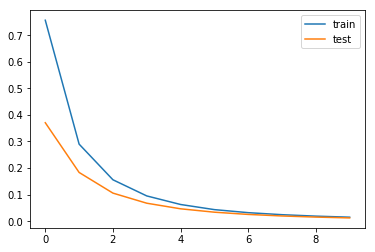

In [131]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [132]:
nn_model.load_weights('./best_model_weights_run1.h5')
preds = nn_model.predict([X_val[f] for f in features])


In [133]:
preds

array([[0.9877771 , 0.01222292],
       [0.9877771 , 0.01222292],
       [0.9877771 , 0.01222293],
       ...,
       [0.9877771 , 0.01222292],
       [0.9877771 , 0.01222292],
       [0.9877771 , 0.01222293]], dtype=float32)

In [134]:
predsDF = pd.DataFrame(data = preds[:,0])
testDF = pd.DataFrame(data = y_val)

In [135]:
min_max_scaler.inverse_transform(y_val.reshape(1,-1))


array([[0.68311548, 0.65650947, 0.66700841, ..., 0.66743293, 0.66678291,
        0.68780411]])

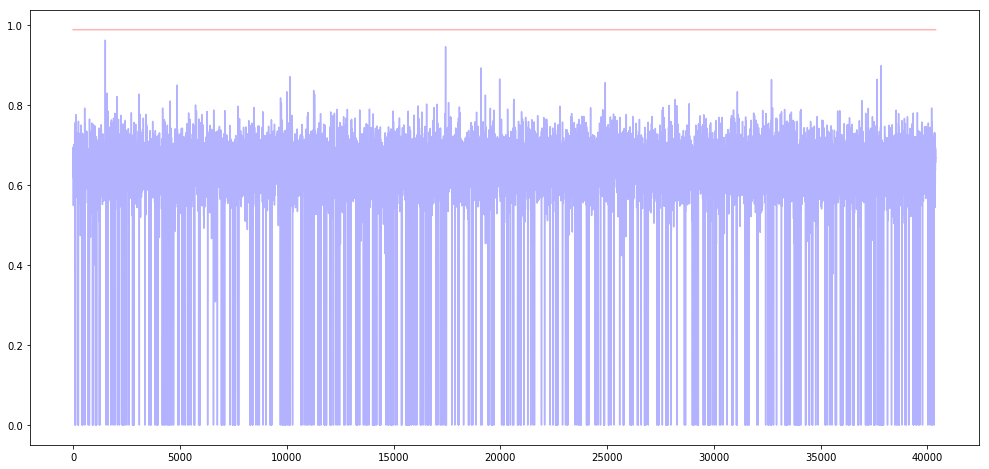

In [136]:
plt.figure(figsize=(17,8))
plt.plot(predsDF,c='red',alpha=0.3)
plt.plot(testDF,c='blue',alpha=0.3)

## ML Benchmark:

In [ ]:
from sklearn.linear_model import LinearRegression

mlTrain = train.drop('target', axis = 1)
mlTrain = mlTrain.drop('first_active_month', axis = 1)
mlTarget = train['target']
lm = LinearRegression()
#lm.fit(mlTrain,mlTarget)

In [ ]:
kf = StratifiedKFold(n_splits=5,random_state=42)
# kf = KFold(n_splits=5,random_state=42)
for tr_ind,val_ind in kf.split(processed_data,target):
    X_train,X_val,y_train,y_val = processed_data.iloc[tr_ind],processed_data.iloc[val_ind],target[tr_ind],target[val_ind]
    nn_model.fit([X_train[f] for f in features],to_categorical(y_train),epochs=25,
                 validation_data=[[X_val[f] for f in features],to_categorical(y_val)],callbacks=set_callbacks())
    break